# Modeling bike-sharing demand
In this notebook, we model the bike-sharing demand at a station-level by a regression model with spatially varying coefficients[1]. The model is similar to the network lasso problem[2]; the only difference is that we use the sum of squared norms instead of the sum of norms in the regularization.

[1] Wang, X., Cheng, Z., Trépanier, M., & Sun, L. (2021). Modeling bike-sharing demand using a regression model with spatially varying coefficients. Journal of Transport Geography, 93, 103059. https://doi.org/10.1016/j.jtrangeo.2021.103059

[2] Hallac, D., Leskovec, J., & Boyd, S. (2015). Network lasso: Clustering and optimization in large graphs. In Proceedings of the 21th ACM SIGKDD international conference on knowledge discovery and data mining (pp. 387-396).

## Data
In `data`, each row represents a bike-sharing station. We use `o_e_peak` (the hourly bike-sharing demand in the afternoon peak) as the dependent variable and factors in the list `f` as independent variables.

In [1]:
from model import *
import pandas as pd
import geopandas as gp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression

data = pd.read_csv('..//data//bikesharing.csv')
data.head()

,Code,name,latitude,longitude,o_m_peak,o_e_peak,num_pop,walkscore,num_university,metro_01,num_poi,den_cycle,den_park,len_road,log_bus_routes,capacity
0,10002,Métro Charlevoix (Centre / Charlevoix),45.478228,-73.569651,5.532026,6.722876,1800.464109,75.0,0,1,17,0.258798,0.033336,3073.572214,1.791759,19.0
1,4000,Jeanne-d'Arc / Ontario,45.549598,-73.541874,2.109804,3.892810,1648.832803,83.0,0,0,28,0.122038,0.000000,2365.306064,1.609438,19.0
2,4001,Graham / Brookfield,45.520075,-73.629776,0.488889,0.656209,981.138605,73.0,0,0,7,0.161553,0.000000,4630.433975,1.945910,23.0
3,4002,Graham / Wicksteed,45.516937,-73.640483,0.998693,1.410458,1243.331455,77.0,0,0,3,0.302279,0.040074,3851.740909,1.791759,19.0
4,5002,St-Charles / Montarville,45.533682,-73.515261,0.201307,0.299346,1618.645949,81.0,0,0,1,0.000000,0.126796,3402.829236,0.000000,11.0


In [2]:
# Independent variables
f = ['num_pop', 'walkscore', 'num_university', 'metro_01', 'num_poi', 'den_cycle', 'den_park', 'len_road',
     'log_bus_routes', 'capacity']
data.loc[:, f].describe()

,num_pop,walkscore,num_university,metro_01,num_poi,den_cycle,den_park,len_road,log_bus_routes,capacity
count,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000
mean,1073.880325,79.278049,0.013008,0.131707,14.939837,0.228156,0.075865,1934.932914,1.281519,23.102439
std,679.596317,16.704534,0.113401,0.338448,14.784818,0.212780,0.142898,913.087624,0.645328,8.609379
min,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,133.264551,0.000000,11.000000
25%,587.789282,73.000000,0.000000,0.000000,4.000000,0.013016,0.000000,1236.488512,1.098612,19.000000
50%,989.834848,83.000000,0.000000,0.000000,10.000000,0.192822,0.000000,1798.252086,1.386294,23.000000
75%,1500.152488,92.000000,0.000000,0.000000,21.000000,0.343084,0.095661,2561.986145,1.609438,27.000000
max,4041.514800,99.000000,1.000000,1.000000,89.000000,1.145032,1.000000,4824.402874,3.295837,105.000000


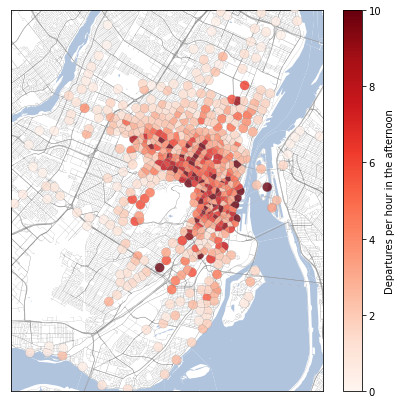

In [3]:
# Plot the demand distribution on a map. 
major_road = gp.read_file('..//data//GIS//road//road_clip_major_project.shp')
minor_road = gp.read_file('..//data//GIS//road//road_clip_minor_project.shp')
water = gp.read_file('..//data//GIS//land_use//water_study.shp')
Thiessen = gp.read_file('..//data//GIS//bikestations//bike_Thiessen_Intersect_dissolve.shp')
Thiessen.set_index('Code', inplace=True)
Thiessen['o_e_peak'] = data.set_index('Code')['o_e_peak']

# %% Plot the demand
fig, ax = plt.subplots(figsize=(7, 7))
style = {"linewidth": 0.2, "alpha": 0.8, "zorder": 50, "edgecolor": 'gray',
         "cmap": 'Reds', "vmin": 0, "vmax": 10, 'clip_on': True}
ax.set_aspect('equal', adjustable='datalim', anchor='C')
water.plot(ax=ax, color='lightsteelblue', label='Water')
major_road.plot(ax=ax, linewidth=0.3, color='gray', label='Street')
minor_road.plot(ax=ax, linewidth=0.15, color='gray')
ax.set(xlim=[290000, 304000], ylim=[5030520, 5050900])
ax.set_yticks([])
ax.set_xticks([])
Thiessen.plot(ax=ax, column='o_e_peak', legend=True,
              legend_kwds={'label': "Departures per hour in the afternoon", 'orientation': "vertical"},
              **style)

## Regression result
We normalize dependent and independent variables into $[0, 1]$. Then, we fit the proposed regression model and compare it with a global linear regression.

In [4]:
data2 = data.copy()  # Normalized data
l = ['o_m_peak', 'o_e_peak'] + f  # Labels to be normalized
data2.loc[:, l] = (data2.loc[:, l] - data2.loc[:, l].min()) / (data2.loc[:, l].max() - data2.loc[:, l].min())
data2['constant'] = 1

# Build a distance matrix
N = data2.shape[0]
dm = np.zeros((N, N))
for i in range(N):
    for j in range(i + 1, N):
        dm[i, j] = dist(data.at[i, 'latitude'], data.at[i, 'longitude'],
                        data.at[j, 'latitude'], data.at[j, 'longitude'])
dm = dm + dm.T

In [5]:
features = data2.loc[:, f + ['constant']].values
target = data2.loc[:, 'o_e_peak'].values

# The proposed regression model. The hyper-parameters are pre-tuned.
model = RegressionGraph(dm, features, target, num_nei=4, alpha=1, lam=2.5)
model.fit()
coeff = pd.DataFrame(data=model.fitted_beta, index=data2.Code, columns=f+['constant'])

# Fit a global linear regression for comparison
lr = LinearRegression(fit_intercept=False)
lr.fit(features, target)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

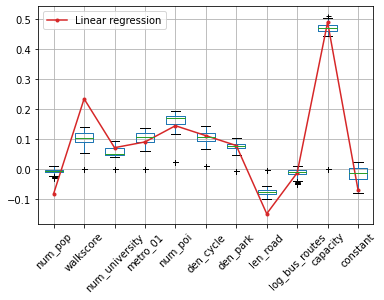

In [6]:
# Compare the coefficients of the proposed model with the global regression.
flierprops = dict(marker='+', markersize=5, markeredgewidth=1)
fig, ax = plt.subplots()
coeff.boxplot(ax=ax, rot=45, widths=0.6, flierprops=flierprops, grid=True)
ax.plot(range(1,12), lr.coef_, '.-',c='C3', label='Linear regression')
ax.legend(loc=2)

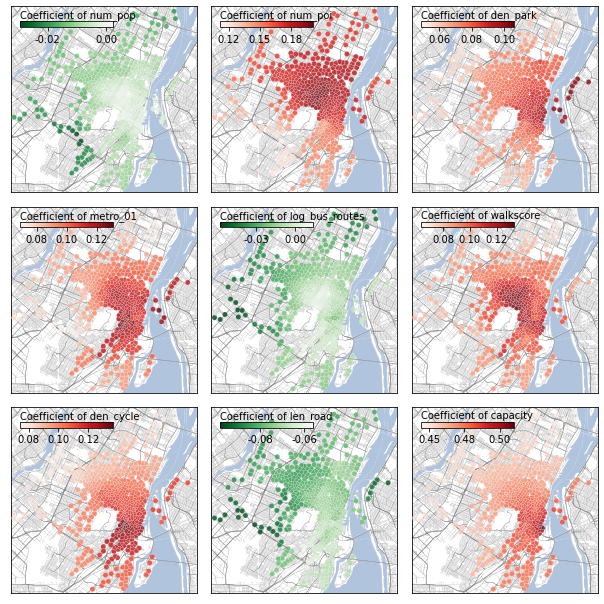

In [7]:
# The spatial distribution for coefficients.
for ff in f:
    Thiessen[ff] = coeff[ff]

# Filter some outliers for better visualization
Thiessen2 = Thiessen.loc[(Thiessen.walkscore >= 0.03), :]

style = {"linewidth": 0.2, "alpha": 0.8, "zorder": 50, "edgecolor": 'white', 'clip_on': True}
f_list = ['num_pop', 'num_poi', 'den_park', 'metro_01', 'log_bus_routes', 'walkscore', 'den_cycle', 'len_road',
          'capacity']

fig, axes = plt.subplots(3, 3, figsize=(8.5, 8.5))
cax_list = []
for i, ax in enumerate(axes.ravel()):
    ax.set_aspect('equal', adjustable='datalim', anchor='C')
    ax.set_yticks([])
    ax.set_xticks([])
    
    # Plot background map
    water.plot(ax=ax, color='lightsteelblue', label='Water')
    major_road.plot(ax=ax, linewidth=0.3, color='gray', label='Street')
    minor_road.plot(ax=ax, linewidth=0.15, color='gray')
    ax.set(xlim=[290000, 304000], ylim=[5034000, 5050900])
    
    # Plot spatial distribution for coefficients
    cmap = 'Reds' if Thiessen2[f_list[i]].mean() > 0 else 'Greens_r'
    cax = ax.inset_axes([0.05, 0.89, 0.5, 0.03], zorder=60)
    cax_list.append(cax)
    Thiessen2.plot(ax=ax, cmap=cmap, column=f_list[i], legend=True, cax=cax,
                   legend_kwds={'orientation': 'horizontal', 'format': '%.2f'}, **style, )
    ax.text(0.05, 0.94, 'Coefficient of {}'.format(f_list[i]),
            transform=ax.transAxes, zorder=52)
fig.set_tight_layout(0.1)

## Out-of-sample prediction

In [8]:
# Generate 20 randomly separated training and test sets.
np.random.seed(1)
K = 20
shuffle = [np.random.permutation(range(N)) for i in range(K)]
train_idx_list = [shuffle[i][0:int(np.floor(N * 0.8))] for i in range(K)]
test_idx_list = [shuffle[i][int(np.floor(N * 0.8)):] for i in range(K)]

Text(0, 0.5, 'RMSE')

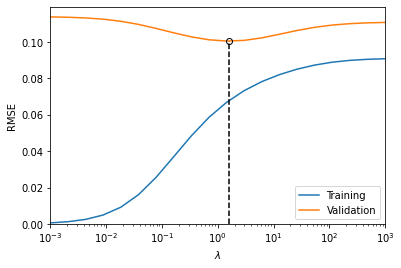

In [9]:
# We can see by tuning a proper lambda, using the regularization can obtain a lower RMSE in the validation/test set.
model.update_train_test(train_idx_list[1], test_idx_list[1])
lam_values = np.logspace(-3, 3, 20)
e_train_list = []
e_test_list = []
for v in lam_values:
    model.lam = v
    model.fit()
    model.predict()
    e_train_list.append(mse(model.train_target, model.fitted_Y)**0.5)
    e_test_list.append(mse(model.test_target, model.predicted_Y)**0.5)

best_lam, e = model.optimize_lam()  # Use one way search to find the optimal lambda 

fig, ax = plt.subplots()
ax.plot(lam_values, e_train_list, label='Training')
ax.plot(lam_values, e_test_list, label='Validation')
ax.plot([best_lam, best_lam],[0, e**0.5], 'k--')
ax.plot(best_lam, e**0.5, 'ok', fillstyle='none')
ax.margins(x=0)
_, u = ax.get_ybound()
ax.set_ybound((0, u))
ax.set_xscale('log')
plt.legend()
ax.set_xlabel('$\lambda$')
ax.set_ylabel('RMSE')

In [10]:
# Out-of-sample predictions of the proposed model.
rmse_list = []
r2_list = []

model.lam = 2.5
for i in range(K):
    model.update_train_test(train_idx_list[i], test_idx_list[i])
    model.fit()
    model.predict()
    rmse_list.append(mse(model.test_target, model.predicted_Y) ** 0.5)
    r2_list.append(r2_score(model.test_target, model.predicted_Y))

print("Test RMSE mean={:.6f}, std={:.6f}".format(np.mean(rmse_list), np.std(rmse_list)))
print("Test R^2 mean={:.6f}, std={:.6f}".format(np.mean(r2_list), np.std(r2_list)))

Test RMSE mean=0.094888, std=0.009572
Test R^2 mean=0.559589, std=0.058532


In [11]:
# Compare with benchmark models.
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
target = 'o_e_peak'

# Using a grid search to determine hyper-parameters for benchmark models.  
model_list = [RandomForestRegressor(random_state=0), SVR(), KNeighborsRegressor()]
search_list = [dict(max_depth=[4,6,8,10, None], n_estimators=[60, 80, 100, 120]),
              dict(kernel=['linear', 'poly', 'rbf',], C=uniform(0.1,2), epsilon=uniform(0.01, 0.3), gamma=['auto', 'scale']),
              dict(n_neighbors=range(3, 15), weights=['uniform', 'distance'])]

for model2, param in zip(model_list, search_list):
    rsc = RandomizedSearchCV(model2, param, random_state=0, n_iter=20, cv=10)
    search = rsc.fit(data2.loc[:, f].values, data2.loc[:, target].values)
    print("Selected parameters {}\n".format(search.best_params_))
    model2.set_params(**search.best_params_)


# Train benchmark models using the same training-test-split 
model_list = [LinearRegression(fit_intercept=True)] + model_list
rmse_result = pd.DataFrame(data=np.zeros((K, 4)), columns=['Linear_reg', 'random_forest', 'SVR', 'KNN'])
r2_result = rmse_result.copy()
for k in range(K):
    train_x = data2.loc[train_idx_list[k], f]
    train_y = data2.loc[train_idx_list[k], target]
    test_x = data2.loc[test_idx_list[k], f]
    test_y = data2.loc[test_idx_list[k], target]
    for i, model2 in enumerate(model_list):
        model2.fit(train_x, train_y)
        rmse_result.iloc[k, i] = mse(test_y, model2.predict(test_x))**0.5
        r2_result.iloc[k, i] = r2_score(test_y, model2.predict(test_x))

print('RMSE of benchmarks:\n {}\n'.format(rmse_result.apply(['mean','std'])))
print('R^2 of benchmarks:\n {}\n'.format(r2_result.apply(['mean','std'])))

Selected parameters {'n_estimators': 120, 'max_depth': 10}

Selected parameters {'C': 1.9046971663479686, 'epsilon': 0.03978410510769216, 'gamma': 'scale', 'kernel': 'rbf'}

Selected parameters {'weights': 'distance', 'n_neighbors': 12}

RMSE of benchmarks:
       Linear_reg  random_forest       SVR       KNN
mean    0.101645        0.10723  0.105351  0.112396
std     0.009608        0.01486  0.013972  0.015214

R^2 of benchmarks:
       Linear_reg  random_forest       SVR       KNN
mean    0.493766       0.442165  0.460540  0.389534
std     0.069694       0.078941  0.075786  0.061233

